## Training Notebook 

### The following cell is a way to get the utility script required for this notebook. 
Since IBM CPD SaaS doesn't have a filesystem, this is the only reliable way to get scripts on the cloud environment.

```
!rm -rf MLOps-CPD && git clone --quiet -b master https://github.com/IBM/MLOps-CPD.git
```

⚠️ Run the following cells only if you are executing on IBM CPD SaaS.

In [ ]:
#!rm -rf MLOps-CPD && git clone --quiet -b master https://github.com/IBM/MLOps-CPD.git

In [ ]:
#!mv MLOps-CPD MLOps_CPD

In [ ]:
!pip install --upgrade pip

In [25]:
!pip install hyperopt ibm_aigov_facts_client ibm_watson_machine_learning lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
anceled
ERROR: Operation cancelled by user


In [26]:
from botocore.client import Config
from ibm_botocore.client import Config
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_confusion_matrix,plot_roc_curve,f1_score,auc,roc_curve,accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from ibm_aigov_facts_client import AIGovFactsClient, CloudPakforDataConfig
from ibm_watson_studio_pipelines import WSPipelines
from ibm_watson_machine_learning import APIClient
import warnings
import os, types
import pandas as pd
import numpy as np
import ibm_boto3
import json
import pickle
import matplotlib.pyplot as plt

from os.path import exists
if exists("utils/fs_utils.py") and exists("utils/catalog_utils.py"):
    from utils import fs_utils,catalog_utils
else:
    # If utils/fs_utils.py and utils/catalog_utils.py exist we assume that you are running on CPD SaaS
    # and will therefore import scripts from the freshly cloned repository
    from MLOps_CPD.utils import fs_utils, catalog_utils

warnings.filterwarnings("ignore")

try:
    import seaborn  as sns
except Exception as e:
    print(str(e) + " - Optional pluging skipped")
    

ModuleNotFoundError: No module named 'lightgbm'

## Ist / soll 

```
## from Notebook 01
validation_params['train_data_path'] = train_data_path
validation_params['test_data_path'] = test_data_path


```

## Pipeline Params

In [24]:
# TODO: Set-up
# CPD_HOST
# CPD_USERNAME
# CPD_PASSWORD

# EXPERIMENT_NAME
# SPACE_ID
# PROJECT_ID

In [ ]:
filename = os.getenv("feature_pickle")

pipeline_path = os.getenv("pipeline_path")
train_data_path = os.getenv("train_data_path")
test_data_path = os.getenv("test_data_path")

In [ ]:
CLOUD_API_KEY = "t9_rVHDftt3jhZCU1nDfEV7fZbtW97MsqmPunvgiOeSP"
filename = "feature_encode.pickle"

pipeline_path = "feature_encode.pickle"
train_data_path = "mlops-dir/train_gcr.csv"
test_data_path = "mlops-dir/test_gcr.csv"
path = "mlops-dir"

In [ ]:
CLOUD_API_KEY = os.getenv("cloud_api_key")

# Model parameters
MODEL_NAME =os.getenv("model_name")
DEPLOYMENT_NAME =os.getenv("deployment_name")

# Watson Studio parameters
project_id = os.environ['PROJECT_ID']
space_id = os.getenv("model_name")
CATALOG_NAME = os.getenv("catalog_name")

## Utility Functions

In [32]:
def check_for_file_in_filesystem(path):
    """
    Check existence of path in filesystem
    """
    if os.path.exists(path):
        return True
    else:
        print("File not found in specified path.")
        return False     

def read_data_from_mlops_cos(key):
    def __iter__(self): return 0
    MLOPS_DATA_STORE_client = ibm_boto3.client(
        service_name='s3',
        ibm_api_key_id=API_KEY_MLOPS,
        ibm_service_instance_id=CRN_MLOPS,
        ibm_auth_endpoint=AUTH_ENDPOINT,
        config=Config(signature_version='oauth'),
        endpoint_url=ENDPOINT_URL_MLOPS)

    body = MLOPS_DATA_STORE_client.get_object(Bucket=BUCKET_MLOPS, Key=key)['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    gcf_df = pd.read_csv(body)
    return gcf_df

def load_model(key, filename):
    check_for_file_in_filesystem(filename)
    with open (filename,"rb") as f:
        pipeline = pickle.load(f)
    return pipeline

def load_data_from_filesystem(path):
    """
    Check existence of path in filesystem.
    If it does exist, loads csv via path
    If it does NOT exist, try to load data from Db2
    """
    body = check_for_file_in_filesystem(path)
    if body:
        suffix = path[-3:]
        # Check whether path ends on csv
        if suffix == "csv":
            gcf_df = pd.read_csv(path)
        else:
            with open(path) as f:
                gcf_df = pickle.load(f)

        return gcf_df
    else:
        print("\n")
        print(f"{path} file/path is probably not in project. Loading File from MLOps COS Bucket.")

        data_request = {
                'connection_name': """DB2_DATA""",
                'interaction_properties': {
                    'select_statement': 'SELECT * FROM "CUSTOMER_DATA"."GERMAN_CREDIT_RISK_TRAINING" FETCH FIRST 5000 ROWS ONLY'
                }
            }

        gcf_df = read_data_from_db2(data_request)
        return gcf_df


def read_data_from_db2(data_request):
    """
    
    If load_data_from_filesystem fails, this method is executed.
    """
    read_client = itcfs.get_flight_client()
    DB2_DATA_data_request = {
        'connection_name': """DB2_DATA""",
        'interaction_properties': {
            'select_statement': 'SELECT * FROM "CUSTOMER_DATA"."GERMAN_CREDIT_RISK_TRAINING" FETCH FIRST 5000 ROWS ONLY'
        }
    }

    flightInfo = itcfs.get_flight_info(read_client, nb_data_request=data_request)

    df = itcfs.read_pandas_and_concat(read_client, flightInfo, timeout=240)
    return df

def save_data_in_filesystem(df,filename):
    """
    Save Data in Filesystem

    Passed filename should involve path

    """
    try:
        if filename[-3:] == "csv":
            df.to_csv(filename,index=False)
            print(f"File {filename} persisted successfully as csv")
        else:
            with open(filename, 'wb') as f:
                pickle.dump(df, f)
            print(f"File {filename} pickled successfully")
    except Exception as e:
        print(e)
        print(f"File serialization for {filename} failed")

In [33]:
# The code was removed by Watson Studio for sharing.

## Load the Saved Transformer from IBM COS 

In [34]:
pipeline = load_model(pipeline_path, pipeline_path)

## Instantiate FactSheets Client

In [ ]:
# SaaS or CPD on-prem?
# facts_client = AIGovFactsClient(experiment_name="mlops-simple-usecase")
# facts_client.assets.get_cpd_version()

In [ ]:
cpd_creds = CloudPakforDataConfig(service_url=CPD_HOST,username=CPD_USERNAME,password=CPD_PASSWORD)
facts_client = AIGovFactsClient(experiment_name=EXPERIMENT_NAME,container_type=SPACE_ID,container_id=PROJECT_ID,cloud_pak_for_data_configs=cpd_creds)

## Load Train Data and Test Data 

In [38]:
train_data = load_data_from_filesystem(train_data_path)
test_data = load_data_from_filesystem(test_data_path)
train_data.head()

,LoanDuration,LoanAmount,InstallmentPercent,CurrentResidenceDuration,Age,ExistingCreditsCount,Dependents,Telephone,Job,ExistingSavings,OthersOnLoan,CreditHistory,CheckingStatus,Housing,OwnsProperty,LoanPurpose,EmploymentDuration,Sex,Risk
0,18,462,2,2,37,2,1,none,skilled,less_100,none,credits_paid_to_date,less_0,own,savings_insurance,car_new,1_to_4,female,0
1,15,250,2,3,28,2,1,yes,skilled,less_100,none,prior_payments_delayed,less_0,own,real_estate,furniture,1_to_4,male,0
2,28,6235,3,3,57,2,1,none,skilled,500_to_1000,none,prior_payments_delayed,no_checking,own,unknown,education,greater_7,male,1
3,9,1032,3,4,41,1,1,none,management_self-employed,100_to_500,none,prior_payments_delayed,no_checking,own,savings_insurance,car_new,4_to_7,male,0
4,11,4553,3,3,22,1,1,none,management_self-employed,less_100,none,credits_paid_to_date,0_to_200,own,savings_insurance,car_new,less_1,female,0


## Load train and test set

In [39]:
y_train = train_data['Risk']

y_test = test_data['Risk']


X_train = train_data.drop('Risk',axis=1)

X_test = test_data.drop('Risk',axis=1)


## Make validation set

In [40]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

## Instantiate a Classifier 

In [41]:
from lightgbm import LGBMClassifier

model_lgb = LGBMClassifier(learning_rate=0.09,max_depth=5,random_state=42)

## Append the Pipeline

In [42]:
estimator_step = ['model_lgb',model_lgb]
pipeline.steps.append(estimator_step)
# if len(pipeline) >2:
#     pipeline= list(pipeline[0]).append(pipeline[-1])

In [43]:
pipeline.steps[0][1].fit(X_tr)

ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                 Index(['Telephone', 'Job', 'ExistingSavings', 'OthersOnLoan', 'CreditHistory',
       'CheckingStatus', 'Housing', 'OwnsProperty', 'LoanPurpose',
       'EmploymentDuration', 'Sex'],
      dtype='object')),
                                ('num', MinMaxScaler(),
                                 Index(['LoanDuration', 'LoanAmount', 'InstallmentPercent',
       'CurrentResidenceDuration', 'Age', 'ExistingCreditsCount',
       'Dependents'],
      dtype='object'))])

## Baseline Model 

In [46]:
# model_pipeline = pipeline.fit(X_train,y_train)
# model_pipeline = pipeline.fit(X_tr,y_tr,model_lgb__verbose=5, model_lgb__eval_set=[(pipeline.steps[0][1].transform(X_val), y_val),(pipeline.steps[0][1].transform(X_tr), y_tr)])
model_pipeline = pipeline.fit(X_tr,y_tr, model_lgb__eval_set=[(pipeline.steps[0][1].transform(X_val), y_val),(pipeline.steps[0][1].transform(X_tr), y_tr)])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1045, number of negative: 2151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 3196, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326971 

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

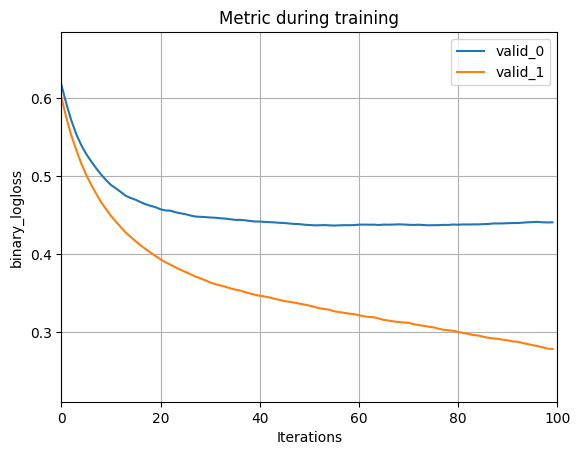

In [47]:
from lightgbm import plot_metric
plot_metric(pipeline.steps[1][1])

## Log the Train and Val loss

In [48]:
val_loss = pipeline.steps[1][1].evals_result_['valid_0']
train_loss = pipeline.steps[1][1].evals_result_['valid_1']

## Save train and val loss to COS

In [57]:
val_loss_path = os.path.join(path, 'val_loss.pkl')
save_data_in_filesystem(val_loss, val_loss_path)

train_loss_path = os.path.join(path, 'train_loss.pkl')
save_data_in_filesystem(train_loss, train_loss_path)

File mlops-dir/val_loss.pkl pickled successfully
File mlops-dir/train_loss.pkl pickled successfully


## Check if the files are copied in COS


In [58]:
files_copied_in_cos = check_for_file_in_filesystem(val_loss_path) and check_for_file_in_filesystem(train_loss_path)
files_copied_in_cos

True

## Baseline Results of the Model

In [59]:
predictions = pipeline.predict(X_test)

print(roc_auc_score(y_test,predictions))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.7175182385975962


In [60]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
scores = np.mean(cross_val_score(pipeline,X_train,y_train, cv=cv, n_jobs=-1,scoring='roc_auc'))
print(f"The Cross Validated AUC_ROC Score is {scores}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1071, number of negative: 2125
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1046, number of negative: 2150
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force

In [61]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(pipeline.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(pipeline.score(X_test, y_test)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training set score: 0.8658
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Test set score: 0.7711


In [62]:
df_cm = confusion_matrix(y_test,predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2,v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

try:
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
except Exception as e:
    print(str(e) + " - Seaborn missing, skipping optional heatmap plot.")

name 'sns' is not defined - Seaborn missing, skipping optional heatmap plot.




Area Under Curve: 0.72




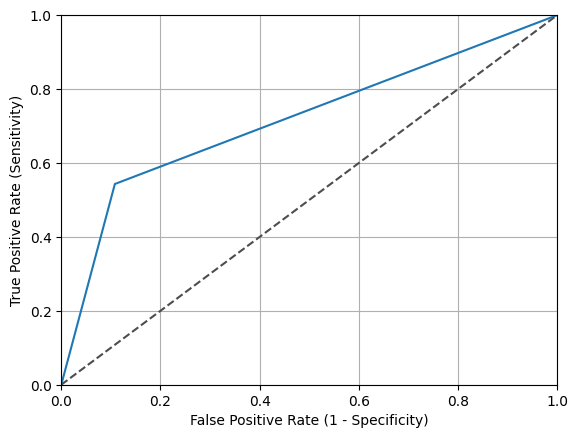

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("\n")
print ("Area Under Curve: %.2f" %auc(fpr, tpr))
print("\n")

## Store Model in the project

In [64]:
with open("model_pipeline.pkl",'wb') as f:
    pickle.dump(model_pipeline,f)

In [65]:
WML_CREDENTIALS = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey": CLOUD_API_KEY
            }

In [66]:
wml_client = APIClient(WML_CREDENTIALS)

## Save and Log Models in AI Factsheets.

In [ ]:
def save_log_facts():
    ctutils = catalog_utils.CatalogUtils(
        service_url="https://api.dataplatform.cloud.ibm.com",
        api_key=CLOUD_API_KEY,
        project_id=project_id,
        auth_url="https://iam.cloud.ibm.com/identity/token")
    catalog_id = ctutils.get_catalog_id_map()[CATALOG_NAME]
    fsutils = fs_utils.FSUtils(wml_client=wml_client,catalog_id=catalog_id,project_id=project_id,bss_account_id='27ff418fedd6aedffb8dc6ae4164a1d2',space_id=space_id,facts_client=facts_client)
    train_ref  = fsutils.prepare_training_reference(apikey=CLOUD_API_KEY,crn=CRN_MLOPS,bucket_name=BUCKET_MLOPS,endpoint=ENDPOINT_URL_MLOPS,training_file_name="german_credit_risk.csv")
    model_id = fsutils.save_model(model=model_pipeline,model_name=MODEL_NAME,model_entry_name="MLOPs",model_entry_description="MLOps Model Entry",target="Risk",X=X_train,y=y_train,train_data_ref=train_ref)
    
    nb_name = "train_models"
    nb_asset_id = "b8d38cab-e373-4303-bd09-12e1086c9132"
    CPD_URL ="https://dataplatform.cloud.ibm.com"

    nb_asset_url = "https://" + CPD_URL + "/analytics/notebooks/v2/" + nb_asset_id + "?projectid=" + project_id + "&context=cpdaas"

    latestRunId = facts_client.runs.list_runs_by_experiment('1').sort_values('start_time').iloc[-1]['run_id']
    facts_client.runs.set_tags(latestRunId, {"Notebook name": nb_name, "Notebook id": nb_asset_id, "Notebook URL" : nb_asset_url})
    facts_client.export_facts.export_payload(latestRunId)

    RUN_ID=facts_client.runs.get_current_run_id()
    facts_client.export_facts.export_payload(RUN_ID)
    
    return model_id


In [ ]:
model_id = save_log_facts()

## Save Params in WS Pipeline

In [ ]:
train_params = {}
train_params['auc_roc'] = float(auc(fpr, tpr))
train_params['training_done'] = True
train_params['model_name'] = MODEL_NAME
train_params['deployment_name'] = DEPLOYMENT_NAME
train_params['model_id'] = model_id
train_params['project_id'] = project_id
# train_params['model_pipeline'] = "/home/wsuser/work/model_pipeline.pkl"

pipelines_client = WSPipelines.from_apikey(apikey=CLOUD_API_KEY)
pipelines_client.store_results(train_params)